# Logistic Regression Model Pipeline

This notebook provides a cell by cell execution machine learning pipeline.  Code is broken out into the following steps:
- #### Library Imports
- #### Data Import and Minor Wrangling
- #### Plot of Churn Distribution (based on user-defined metric)
- #### Split Date into Train/Test
- #### Model Instantiation and Training
- #### Display of Model Results and Interpretability
- #### Save Model for Deployment 
- #### Appendix Section: Training Model with statsmodel API

## Library Imports

In [20]:
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_rows', 1500)

#models an pre-processing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler
#from src.data_functions import wrangle
#w = wrangle()
import statsmodels.api as sm

#metrics
from sklearn.metrics import auc, f1_score, recall_score, roc_curve, precision_recall_curve, classification_report
from sklearn.metrics import confusion_matrix, plot_precision_recall_curve, plot_roc_curve
import sklearn
#from src.model_functions import thresh_selection, odds_to_prob

#model saving
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Import / Wrangling

In [8]:
data = pd.read_csv('../data/model/new_model_data.csv')
len(data)

3193

In [9]:
def remove_new_patients(df, threshold=2000):
    
    #new patients defined as Tenure < 400 and Recency < 400
    new_patients_nums = df[(df['Tenure'] < 400)&(data['Recency'] < 400)]['PatNum']
    new_df = df[~df['PatNum'].isin(new_patients_nums)]
    
    print(f'Total number of new patients:\t  {len(new_patients_nums)}\nTotal Count in new Dataset:\t{len(new_df)}')
    new_df = new_df[new_df["Recency"] < threshold]
    return new_df

In [10]:
fresh = remove_new_patients(data)
fresh.shape

Total number of new patients:	  75
Total Count in new Dataset:	3118


(1603, 16)

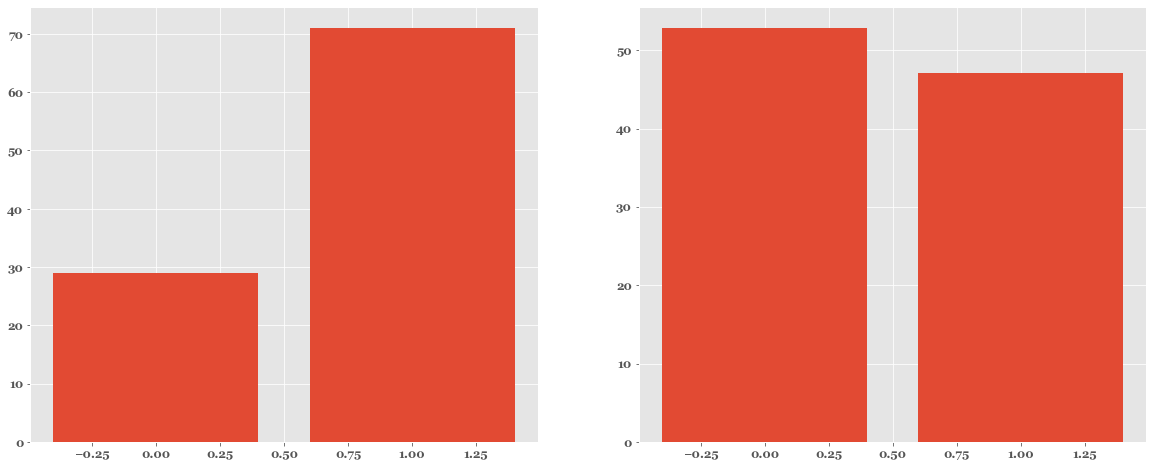

In [11]:
#Sanity check for target distribution in the dataset 
data['churn'] = np.where(data['Recency'] >= 400, 1, 0)
fresh['churn'] = np.where(fresh['Recency'] >= 400, 1, 0)
data_churn_dist = round(data['churn'].value_counts()/len(data) * 100, 2)
fresh_churn_dist = round(fresh['churn'].value_counts()/len(fresh) * 100, 2)
fig = plt.figure(figsize=(20,8))
fig1 = fig.add_subplot(1,2,1)
plot1 = plt.bar(data_churn_dist.index, data_churn_dist)
fgi2 = fig.add_subplot(1,2,2)
plot2 = plt.bar(fresh_churn_dist.index, fresh_churn_dist)

## Churn Distribution Plot

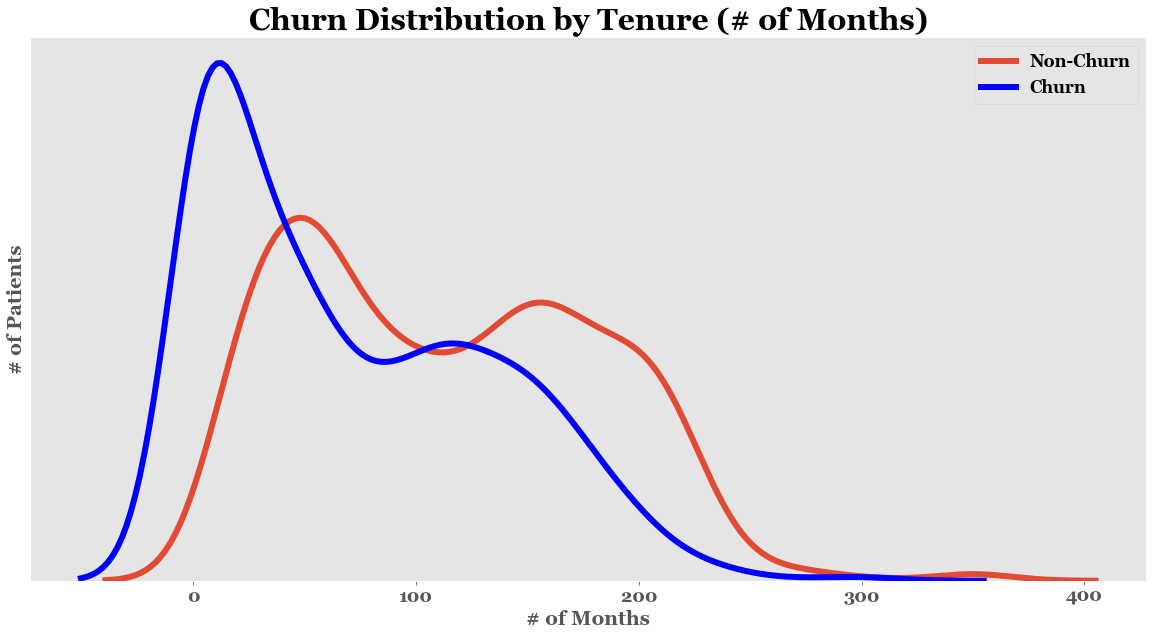

In [12]:
def plot_churn(df):
    plt.style.use('ggplot')
    #tenure_non_churn = df[df['churn'] == 0]['Tenure']/30
    #tenure_churn = df[df['churn'] == 1]['Tenure']/30
    sns.kdeplot(x=df[df['churn'] == 0]['Tenure']/30, lw=6, label='Non-Churn')
    sns.kdeplot(x=df[df['churn'] == 1]['Tenure']/30, lw=6, label='Churn', color='blue')
    #hist_churn = plt.hist(tenure_churn, bins=30, edgecolor='black', lw=2, color='blue', label='Churn')
    #hist_non_churn = plt.hist(tenure_non_churn, bins=30, edgecolor='black', lw=1.5,color='red', alpha=0.4, label='Non-churn')
    leg = plt.legend(fontsize='xx-large')
    title = plt.title('Churn Distribution by Tenure (# of Months)', fontweight='bold', fontsize=30)
    xlabel = plt.xlabel('# of Months', fontweight='bold', fontsize=20)
    ylabel = plt.ylabel('# of Patients', fontweight='bold', fontsize=20)
    xticks = plt.xticks(fontsize=18, fontweight='bold')
    yticks = plt.yticks(ticks=[]) #plt.yticks(fontsize=18, fontweight='bold')
    plt.grid(False)
plot_churn(fresh)

## Extract Label from Data and Scale

In [13]:
def extract(df, drop_cols):
    X = df.drop(drop_cols, axis=1)
    y = df.churn
    print(X.shape, y.shape)
    return X, y

def scale_data(data):
    scaler = StandardScaler()
    Xscaled = scaler.fit_transform(data)
    print(Xscaled.shape)
    return Xscaled

In [14]:
def drop_columns(additional_cols):
    if isinstance(additional_cols, list):
        drop_cols = ['PatNum', 'Recency', 'churn'] + additional_cols
    else:
        drop_cols = ['PatNum', 'Recency', 'churn'] + [additional_cols]
    return drop_cols    

In [15]:
X, y = extract(fresh,['PatNum', 'Recency', 'churn'])

(1603, 14) (1603,)


In [16]:
Xscaled = scale_data(X)

(1603, 14)


## Create Train/Test split

In [17]:
def split_data(X, y, test_size=0.25):
    xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size = test_size)
    print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)
    return xtrain, xtest, ytrain, ytest

In [18]:
xtrain, xtest, ytrain, ytest = split_data(Xscaled, y)

(1202, 14) (401, 14) (1202,) (401,)


In [19]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

## Testing SVM as a model

In [35]:
for x in np.linspace(1.4, 5,10):
    clf = svm.SVC(C=x)
    print(f'Score: {np.mean(cross_val_score(clf, xtrain, ytrain, scoring="recall", cv=5, verbose=1, n_jobs=4))} at C = {x}\n')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Score: 0.7564317841079461 at C = 1.4

Score: 0.7615742128935532 at C = 1.7999999999999998

Score: 0.7633433283358321 at C = 2.2

Score: 0.7616191904047975 at C = 2.6

Score: 0.7598950524737631 at C = 3.0

Score: 0.7598950524737631 at C = 3.4

Score: 0.7650824587706146 at C = 3.8000000000000003

Score: 0.7581709145427287 at C = 4.2

Score: 0.7633433283358322 at C = 4.6

Score: 0.7685307346326836 at C = 5.0



[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


In [36]:
clf.fit(xtrain, ytrain)

SVC(C=5.0)

In [37]:
predictions = clf.predict(xtest)

In [38]:
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       225
           1       0.83      0.72      0.77       176

    accuracy                           0.81       401
   macro avg       0.82      0.80      0.81       401
weighted avg       0.81      0.81      0.81       401



## Instantiate Model and Train

In [232]:
lr = LogisticRegressionCV(solver='liblinear', penalty='l1', max_iter=500, cv=10, scoring='roc_auc')
np.mean(cross_val_score(lr, xtrain, ytrain, scoring='roc_auc', cv=10, ))

0.9002011639676114

In [233]:
lr2 = LogisticRegression(solver='liblinear', penalty='l1', max_iter = 500)
print(np.mean(cross_val_score(lr2, xtrain, ytrain, scoring='roc_auc', cv=10, verbose=1)))

0.8995585041329285


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [234]:
from datetime import datetime
start = datetime.now()
lr.fit(xtrain, ytrain)
total = datetime.now() - start
print(f'{total/60} minutes of run time.')

LogisticRegressionCV(cv=10, max_iter=500, penalty='l1', scoring='roc_auc',
                     solver='liblinear')

0:00:00.004049 minutes of run time.


## Display Model Results

In [235]:
lr.score(xtrain, ytrain)
lr.score(xtest, ytest)

0.9064769007872615

0.8951392001593704

In [236]:
predictions = lr.predict(xtest)
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       207
           1       0.82      0.79      0.81       194

    accuracy                           0.82       401
   macro avg       0.82      0.81      0.82       401
weighted avg       0.82      0.82      0.82       401



In [25]:
def priority_list(original_df, predicted_probas, thresh):
    df = pd.DataFrame(predicted_probas).sort_values(1, ascending=False)
    inds = df[df[1] >= thresh].index
    patients = original_df.loc[inds, :].loc[:, ['PatNum', 'tenure', 'num_visits', 'LastVisit']]
    #patients = patients.sort_values(['LastVisit', 'tenure', 'num_visits'], ascending=[False, False, False])
    return patients


In [151]:
threshold = 0.48
predicted_proba = lr.predict_proba(xtest)
predicted = (predicted_proba [:,1] >= threshold).astype('int')
print(classification_report(ytest, predicted))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       218
           1       0.79      0.84      0.81       183

    accuracy                           0.82       401
   macro avg       0.82      0.82      0.82       401
weighted avg       0.83      0.82      0.82       401



In [152]:
confusion_matrix(ytest, predictions)

array([[183,  35],
       [ 29, 154]])

In [119]:
thresh_selection(xtest, ytest, lr, 0.2, 0.57, 0.02)
curve = plot_roc_curve(lr, xtest, ytest, lw=3)
title = plt.title('ROC Curve for LR Model', fontweight='bold', fontsize=30)
ylabel = plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
xlabel = plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
leg = plt.legend(fontsize='xx-large', loc=10)

NameError: name 'thresh_selection' is not defined

#### Calculating Odds and Probas from Coefficients

In [160]:
def odds_to_prob(log_odds, odds=None):
    '''
    Given log odds returns probability
    
    Parameters:
        log_odds: float or int
    Returns: 
        probability: float
    '''
    odds = np.exp(log_odds)
    p = odds/(1 + odds)
    return p

def create_odds_table(df, model):
    coefs = pd.DataFrame().from_dict(dict(zip(df.columns, model.coef_[0])), orient='index').sort_values(by=0)
    coefs.rename(columns={0:'Log Odds'}, inplace=True)
    coefs['Odds'] = np.exp(coefs['Log Odds'])
    coefs['Probability'] = coefs['Log Odds'].apply(odds_to_prob)
    return coefs

odds_tbl = create_odds_table(X, lr)
odds_tbl

,Log Odds,Odds,Probability
InsEst,-2.167759,0.114434,0.102683
seen_by_10,-1.223190,0.294290,0.227376
Tenure,-0.926527,0.395927,0.283630
seen_by_15,-0.909787,0.402610,0.287043
seen_by_7,-0.335578,0.714925,0.416884
Frequency,0.032964,1.033514,0.508240
age,0.066480,1.068739,0.516614
seen_by_6,0.136527,1.146286,0.534079
Total,0.152745,1.165027,0.538112
EstBalance,0.169828,1.185100,0.542355


In [93]:
def conv(logit):
    return (round(np.exp(logit),3), round(odds_to_prob(logit),3))
def math(score):
    return -9.79 + 0.1563*score

In [158]:
odds_to_prob(0.0590632)

(0.5147615090030409, 0.5147615090030409)

## Save Model for Deployment

In [342]:
pickle_filename = "src/bestLRmodel.pkl"  

with open(pickle_filename, 'wb') as file:  
    pickle.dump(lr, file)

In [343]:
churns = lr.predict_proba(xtest)[:,1]
nonchurns = lr.predict_proba(xtest)[:,0]

## Appendix: Logistic Regression with statsmodel API

In [344]:
log_reg = sm.Logit(ytrain, xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.390556
         Iterations 8


In [345]:
print(log_reg.summary(xname=X.columns.tolist()))

                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 1202
Model:                          Logit   Df Residuals:                     1188
Method:                           MLE   Df Model:                           13
Date:                Mon, 11 Jan 2021   Pseudo R-squ.:                  0.4361
Time:                        21:10:22   Log-Likelihood:                -469.45
converged:                       True   LL-Null:                       -832.56
Covariance Type:            nonrobust   LLR p-value:                8.494e-147
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Gender        -0.0585      0.083     -0.705      0.481      -0.221       0.104
EstBalance     0.1374      0.124      1.105      0.269      -0.106       0.381
InsEst        -1.1963      0.299     -4.005      0.0

In [161]:
lr.classes_

array([0, 1])

In [162]:
lr.coef_

array([[ 0.16982754, -2.16775908,  0.06647988,  0.45308481,  0.13652685,
        -0.33557774, -1.2231903 , -0.90978679,  0.0329643 , -0.9265266 ,
         0.15274468]])

In [179]:
from sklearn.ensemble import RandomForestClassifier

In [306]:
data_dict = {}

for x in [None, 'auto', 'log2']:
    rf = RandomForestClassifier(n_estimators=250, max_depth=16, n_jobs=-1, max_features='log2')
    rf.fit(xtrain, ytrain)
    train_preds = rf.predict(xtrain)
    test_preds = rf.predict(xtest)
    #print(f'Training: {f1_score(ytrain, train_preds)}')
    #print(f'Test: {f1_score(ytest, test_preds)}')
    #print(f'Test Recall: {recall_score(ytest, test_preds)}')
    data_dict[x] = [f1_score(ytrain, train_preds), f1_score(ytest, test_preds), recall_score(ytest, test_preds)]

RandomForestClassifier(max_depth=16, max_features=None, n_estimators=250,
                       n_jobs=-1)

RandomForestClassifier(max_depth=16, n_estimators=250, n_jobs=-1)

RandomForestClassifier(max_depth=16, max_features='log2', n_estimators=250,
                       n_jobs=-1)

,Train,Test,Recall
NaN,1.0,0.797583,0.737430
auto,1.0,0.810811,0.754190
log2,1.0,0.819277,0.759777


ValueError: could not convert string to float: 'auto'

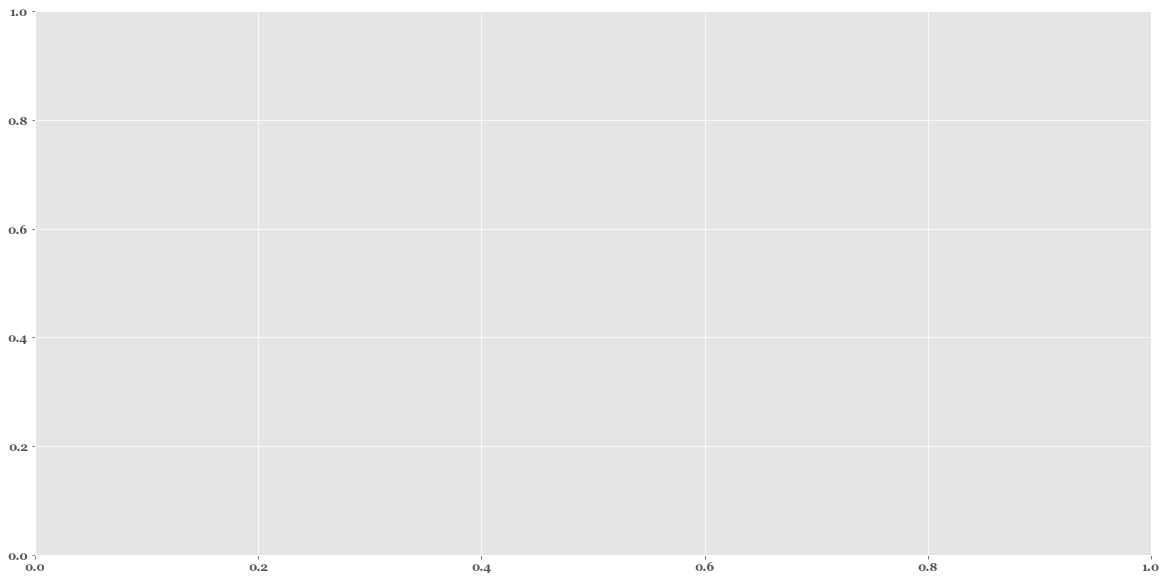

In [307]:
df = pd.DataFrame.from_dict(data_dict, orient='index', columns=['Train', 'Test', 'Recall'])
df
plot = plt.plot(df.index, df.Train, label='Train')
plot = plt.plot(df.index, df.Test, label='Test')
plot = plt.plot(df.index, df.Recall, label='Recall')
leg = plt.legend(fontsize='xx-large')

In [308]:
rf = RandomForestClassifier(n_estimators=250, max_depth=16, n_jobs=-1, max_features='log2')

In [309]:
rf.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=16, max_features='log2', n_estimators=250,
                       n_jobs=-1)

In [310]:
rf.score(xtrain, ytrain)
rf.score(xtest, ytest)

0.9983361064891847

0.8553615960099751

In [316]:
cross_val_score(rf, xtrain, ytrain, scoring='roc_auc', cv=10)

array([0.93404488, 0.91215107, 0.8948832 , 0.91685206, 0.92157953,
       0.90989989, 0.91464773, 0.90991367, 0.90128098, 0.85018101])

In [311]:
rfpreds = rf.predict(xtest)
print(classification_report(ytest, rfpreds))

              precision    recall  f1-score   support

           0       0.83      0.92      0.88       222
           1       0.89      0.77      0.83       179

    accuracy                           0.86       401
   macro avg       0.86      0.85      0.85       401
weighted avg       0.86      0.86      0.85       401



In [312]:
threshold = 0.48
predicted_proba = rf.predict_proba(xtest)
predicted = (predicted_proba [:,1] >= threshold).astype('int')
print(classification_report(ytest, predicted))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       222
           1       0.89      0.79      0.84       179

    accuracy                           0.86       401
   macro avg       0.87      0.86      0.86       401
weighted avg       0.87      0.86      0.86       401



In [81]:
from sklearn.linear_model import LinearRegression, Ridge
lr = LinearRegression()

In [50]:
def plot_data(X, y, model):
    model.fit(X,y)
    preds = model.predict(X)
    plot = plt.scatter(X,y, color='black', marker='o')
    _ = plt.plot(X, preds, color='red', marker='o')

In [90]:
X = np.linspace(0,10,10).reshape(-1, 1)
y = [x*np.random.uniform() + 2.2 for x in X]
y[-1] = 150

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2831: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _data = np.array(data, dtype=dtype, copy=copy,


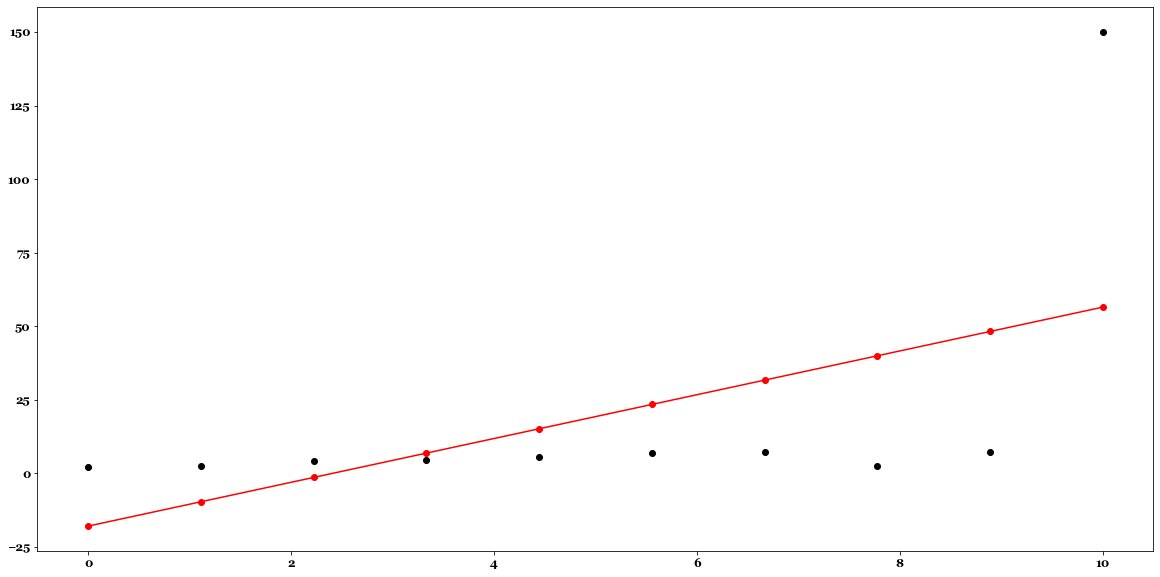

In [91]:
plot_data(X,y, lr)

In [92]:
lr.intercept_, lr.coef_, 

(-17.87352225721585, array([7.43733563]))

In [93]:
lr.predict(X)

array([-17.87352226,  -9.609816  ,  -1.34610975,   6.9175965 ,
        15.18130275,  23.44500901,  31.70871526,  39.97242151,
        48.23612777,  56.49983402])

In [94]:
np.mean((y - lr.predict(X))**2)

<ipython-input-94-c977f527fa4c>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.mean((y - lr.predict(X))**2)


array([1337.73607923])

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2831: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _data = np.array(data, dtype=dtype, copy=copy,


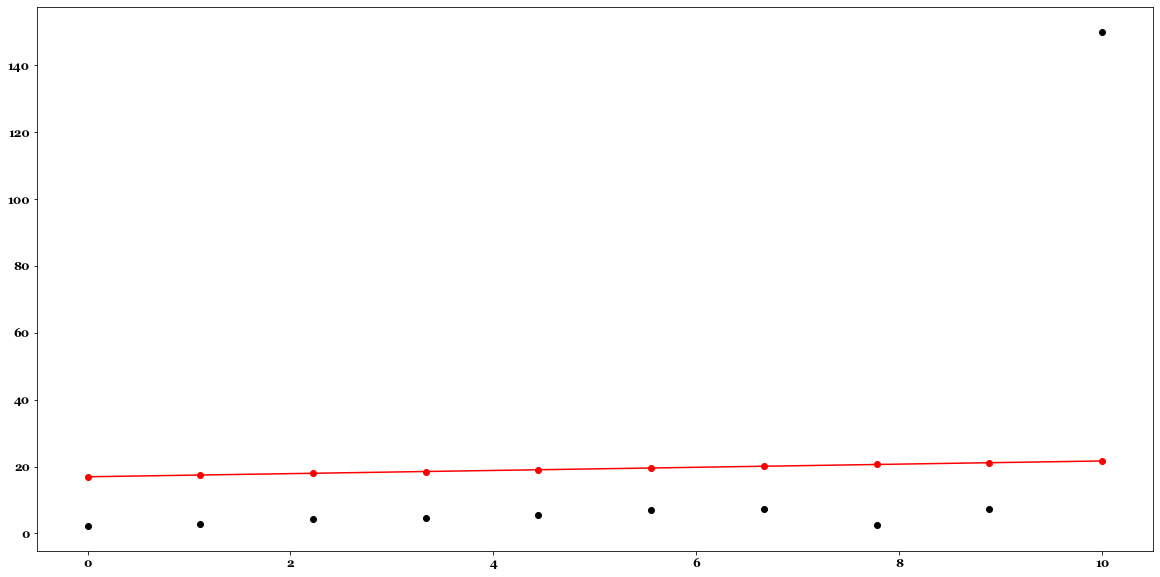

In [106]:
ridge = Ridge(alpha=1500)
plot_data(X, y, ridge)


In [104]:
np.mean((y - ridge.predict(X))**2)

<ipython-input-104-65a901284c80>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.mean((y - ridge.predict(X))**2)


array([1726.57031564])

In [107]:
ridge.intercept_, ridge.coef_, 

(16.948685016992968, array([0.47289417]))

In [21]:
def gini(yes, no):
    return 1 - (yes/(yes+no))**2 - (no/(yes+no))**2
def weighted_avg(gini_left, gini_right, total_left, total_right):
    return (total_left/(total_left + total_right) * gini_left) + (total_right/(total_left + total_right) * gini_right)

In [26]:
blocked_left = gini(37, 127)

In [27]:
blocked_right = gini(100, 33)

In [28]:
blocked_left, blocked_right

(0.3494199881023201, 0.373113234213353)

In [29]:
weighted_avg(blocked_left, blocked_right, 37+127, 133)

0.3600300949466547

In [17]:
(92/(92+31))**2

0.5594553506510674

In [30]:
wl = gini(1, 2)
wr = gini(2,0)

In [31]:
wl, wr

(0.4444444444444444, 0.0)

In [32]:
weighted_avg(wl, wr, 3, 2)

0.26666666666666666

In [33]:
0.444444 * 0.6

0.26666639999999997